# Closed-form velocity

There are two primary workflows for computing the Finite-Time Lyapunov Exponent (FTLE) field using pyFTLE:

1. **File-based I/O for Production Runs**: This approach is designed for large-scale simulations, where the velocity field data is read from external files.
2. **Jupyter Notebook-Friendly API**: A more interactive approach, allowing results to be computed and displayed directly in memory, with analytical functions of the velocity field being passed in.

In this notebook, we focus on the **second workflow**, using the **helical vortex problem** as a toy example to illustrate the capabilities of the solver.

### Velocity Field Definition

The first step in the demonstration is defining the velocity function that describes the flow. In our toy example, we have a **closed-form expression** for the velocity field at any point in space and time. This enables efficient computation, as there's no need for interpolation during the time integration of particles to compute the FTLE field. The solver takes advantage of this to speed up the calculations and expose a user-friendly API for efficient FTLE computation.

> **Practical Use Case: Simulation and Experiment Data**
> 
> In real-world applications, we often don't have a closed-form expression for the velocity field. Instead, the velocity field is typically obtained from simulations or experiments and stored in files. In these cases, the solver can read the velocity data from disk.
>
> While this notebook focuses on demonstrating the in-memory API, it also provides insights into **how to generate the input files** expected by the solver for a **file-based production run**.
>
> By understanding both workflows, you'll be able to choose the most suitable method for your use case—whether it’s for quick prototyping in Jupyter or scaling up to full-scale production runs with large datasets.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def velocity_fn(t,coordinates):
    """
    Velocity field of a helical vortex filament spinning around the z-axis.

    Parameters
    ----------
    X, Y, Z : ndarray
        3D meshgrid coordinates.
    k : float
        Helical wavenumber (2π / pitch).
    R0 : float
        Radius of the helical centerline.
    Gamma : float
        Circulation strength.
    sigma : float
        Core radius.
    phi : float
        Global rotation phase (advances with time).
    """
    velocities = np.empty_like(coordinates)
    
    local_X = coordinates[:,0]
    local_Y = coordinates[:,1]
    local_Z = coordinates[:,2]
        
    Lz = 8.0
    R0 = 1.0
    Gamma = 5.0
    sigma = 0.3
    omega = 2*np.pi/2.0
    k = 8*np.pi/Lz
    phi = omega*t
    
    # Helical vortex centerline coordinates (rotating in time)
    xc = R0 * np.cos(k * local_Z + phi)
    yc = R0 * np.sin(k * local_Z + phi)

    # Local coordinates relative to vortex centerline
    Xr = local_X - xc
    Yr = local_Y - yc
    R = np.sqrt(Xr**2 + Yr**2)
    theta = np.arctan2(Yr, Xr)

    # Tangential velocity profile (Gaussian-like)
    v_theta = Gamma / (2 * np.pi * R) * (1 - np.exp(-((R / sigma) ** 2)))

    # Swirl velocity components around the local vortex axis
    u = -v_theta * np.sin(theta)
    v = v_theta * np.cos(theta)

    # Add a weak axial component for corkscrew character
    w = 0.2 * Gamma / (2 * np.pi * R0) * np.exp(-((R / sigma) ** 2))

    mag = np.sqrt(u**2 + v**2 + w**2)
    scale = np.max(mag)
    u, v, w = u / scale, v / scale, w / scale

    velocities[:,0] = u
    velocities[:,1] = v
    velocities[:,2] = w
    
    
    return velocities


### Create the physical domain and evaluate the velocity field on it

(4194304, 3)


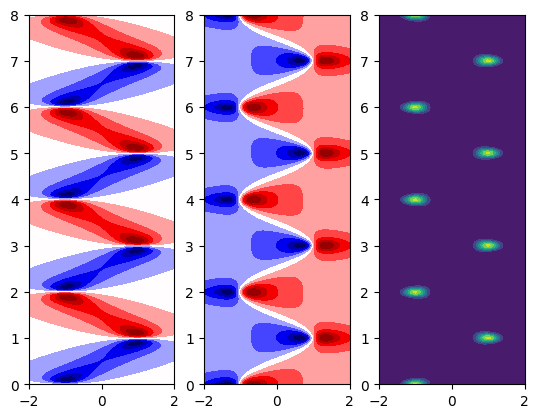

In [2]:
Nx, Ny, Nz = 128, 128, 256
Lx, Ly, Lz = 4.0, 4.0, 8.0
Lxp, Lyp, Lzp = 3.8, 3.8, 2 * 3.8

x = np.linspace(-Lx / 2, Lx / 2, Nx)
y = np.linspace(-Ly / 2, Ly / 2, Ny)
z = np.linspace(0, Lz, Nz)

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

coord_x = X.flatten()
coord_y = Y.flatten()
coord_z = Z.flatten()
coordinates = np.stack((coord_x, coord_y, coord_z), axis=1)

# Here is how we call the function to generate the velocity field at a specific time
t = 1  # desired time
vel = velocity_fn(t, coordinates)
print(vel.shape)
u = vel[:,0].reshape(X.shape)
v = vel[:,1].reshape(X.shape)
w = vel[:,2].reshape(X.shape)


#slice velocity field x, z plane
X_slice = X[:,Ny//2,:]
Y_slice = Y[:,Ny//2,:]
Z_slice = Z[:,Ny//2,:]

u_slice = u[:,Ny//2,:]
v_slice = v[:,Ny//2,:]
w_slice = w[:,Ny//2,:]

fig, ax = plt.subplots(1,3)
ax[0].contourf(X_slice,Z_slice, u_slice, cmap = 'seismic', levels = np.linspace(-1,1,12))
ax[1].contourf(X_slice,Z_slice, v_slice, cmap = 'seismic', levels = np.linspace(-1,1,12))
ax[2].contourf(X_slice,Z_slice, w_slice)

#ax[0].set_aspect('equal')
##ax[1].set_aspect('equal')
#ax[2].set_aspect('equal')


plt.show()


### Create Particles

In this step, we define the **neighboring particles** required by the solver to compute the FTLE (Finite-Time Lyapunov Exponent) field.

These neighboring particles are essential because they allow us to evaluate how small regions deform over time. By integrating the trajectories of a group of nearby particles, we can measure their relative displacement and calculate the deformation gradient, which is used to compute the FTLE. The resulting FTLE value is then assigned to the **centroid** of the particle group.

For this 3D problem, we define six neighboring particles positioned to the **left**, **right**, **top**, **bottom**, **front** and **back** of each centroid.

To simplify the implementation, we first define a set of **centroid positions**, where the FTLE values will be evaluated. We then determine the positions of their neighboring particles by applying vertical and horizontal spacing offsets.

> **Note:** In the example below, we create a coarse particle distribution for demonstration purposes. In the next step, we’ll increase the resolution for the actual FTLE computation.


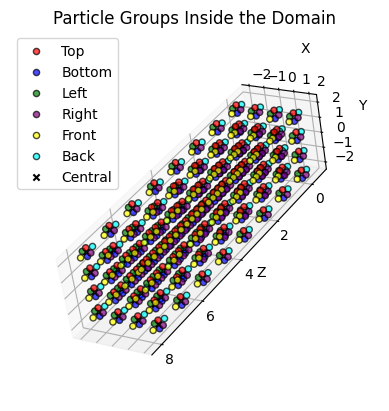

In [3]:
# Create a grid of central locations
Lxp, Lyp, Lzp = 3.8, 3.8, 2 * 3.8 #note that this domain is a subset of the original velocity field
Nxp, Nyp, Nzp = 4, 4, 8
xp = np.linspace(-Lxp / 2, Lxp / 2, Nxp)
yp = np.linspace(-Lyp / 2, Lyp / 2, Nyp)
zp = np.linspace(0, Lzp, Nzp)

Xp, Yp, Zp = np.meshgrid(xp, yp, zp, indexing="ij")

# Now, define the neighboring locations
dx = np.min(np.gradient(xp)) / 2
dy = np.min(np.gradient(yp)) / 2
dz = np.min(np.gradient(zp)) / 2

delta =  0.5*np.min((dx,dy,dz))

Xc, Yc, Zc = Xp, Yp, Zp

central_locations = np.column_stack((Xc.ravel(), Yc.ravel(), Zc.ravel()))
particles = {
        "top": np.column_stack(((Xc).ravel(), (Yc + delta).ravel(), Zc.ravel())),
        "bottom": np.column_stack(((Xc).ravel(), (Yc - delta).ravel(), Zc.ravel())),
        "left": np.column_stack(((Xc - delta).ravel(), Yc.ravel(), Zc.ravel())),
        "right": np.column_stack(((Xc + delta).ravel(), Yc.ravel(), Zc.ravel())),
        "front": np.column_stack((Xc.ravel(), Yc.ravel(), (Zc + delta).ravel())),
        "back": np.column_stack((Xc.ravel(), Yc.ravel(), (Zc - delta).ravel())),
            }


particles_plot = {
    "top": (particles["top"], "red", "Top"),
    "bottom": (particles["bottom"], "blue", "Bottom"),
    "left":   (particles["left"], "green", "Left"),
    "right": (particles["right"], "purple", "Right"),
    "front": (particles["front"], "yellow", "Front"),
    "back": (particles["back"], "cyan", "Back"),
}


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_aspect("equal", "box")
# ax.set_xlim((x_min, x_max))
# ax.set_ylim((y_min, y_max))
ax.set_title("Particle Groups Inside the Domain")
ax.set_aspect('equal')
for key, (coords, color, label) in particles_plot.items():
    ax.scatter(
        coords[::, 0],
        coords[::, 1],
        coords[::, 2],
        color=color,
        label=label,
        alpha=0.7,
        edgecolors="black",
    )

# Scatter plot for central locations (black)
ax.scatter(
    central_locations[::, 0],
    central_locations[::, 1],
    central_locations[::, 2],
    color="black",
    label="Central",
    marker="x",
)
ax.legend()
ax.view_init(elev=45, azim=45, roll=135)
ax.set_box_aspect(aspect=(1, 1, 4)) 
plt.show()

In [4]:
from pyftle.particles import NeighboringParticles


Nxp, Nyp, Nzp = 64, 64, 128
xp = np.linspace(-Lxp / 2, Lxp / 2, Nxp)
yp = np.linspace(-Lyp / 2, Lyp / 2, Nyp)
zp = np.linspace(0, Lzp, Nzp)

Xp, Yp, Zp = np.meshgrid(xp, yp, zp, indexing="ij")

# Now, define the neighboring locations
dx = np.min(np.gradient(xp)) / 2
dy = np.min(np.gradient(yp)) / 2
dz = np.min(np.gradient(zp)) / 2

delta =  0.5*np.min((dx,dy,dz))

Xc, Yc, Zc = Xp, Yp, Zp

central_locations = np.column_stack((Xc.ravel(), Yc.ravel(), Zc.ravel()))
particles = {
        "top": np.column_stack(((Xc).ravel(), (Yc + delta).ravel(), Zc.ravel())),
        "bottom": np.column_stack(((Xc).ravel(), (Yc - delta).ravel(), Zc.ravel())),
        "left": np.column_stack(((Xc - delta).ravel(), Yc.ravel(), Zc.ravel())),
        "right": np.column_stack(((Xc + delta).ravel(), Yc.ravel(), Zc.ravel())),
        "front": np.column_stack((Xc.ravel(), Yc.ravel(), (Zc + delta).ravel())),
        "back": np.column_stack((Xc.ravel(), Yc.ravel(), (Zc - delta).ravel())),
            }

# positions must be in this order!
positions = np.stack((particles["left"], particles["right"], particles["top"], particles["bottom"], particles["front"], particles["back"]), axis=1).reshape(
    -1, 3, order="F"
)

particles = NeighboringParticles(positions)


# Optional: save particles to a file
save_particles = False

if save_particles:
    import os
    from scipy.io import savemat

    output_dir = "./"
    filename = os.path.join(output_dir, "particles.mat")
    savemat(filename, p)

ModuleNotFoundError: No module named 'pyftle'

We now have the neighboring particle groups defined, along with a function that returns the velocity field at any given time $t$. This means we're almost ready to compute the FTLE for this velocity field.

What remains is to specify the **integration period**—the time interval over which the flow map will be evaluated—and the **timestep** for the numerical integration.

The final step is to **instantiate the solver and run it**. Since we're using an analytical function to represent the velocity field, we need to use the `AnalyticalSolver` for this purpose.

In [ ]:
from pyftle import AnalyticalSolver

timestep = -0.01
flow_map_period = 0.02

solver = AnalyticalSolver(
    velocity_fn=velocity_fn,
    particles=particles,
    timestep=timestep,
    flow_map_period=flow_map_period,
    num_ftles=1,
    integrator_name="euler",
)

ftle_field = solver.run()

print('Done')

You can also specify the number of FTLE fields to compute. In the following example, we request 4 consecutive FTLE fields, which will be processed in parallel using 2 processors.

In [ ]:
from pyftle import AnalyticalSolver
import pyvista as pv
import warnings
warnings.filterwarnings("ignore", message="Failed to use notebook backend")

timestep = -0.01
flow_map_period = 0.02

num_ftles = 4

solver = AnalyticalSolver(
    velocity_fn=velocity_fn,
    particles=particles,
    timestep=timestep,
    flow_map_period=flow_map_period,
    num_processes=2,  # Run FTLEs in parallel
    num_ftles=num_ftles,  # Select the number of FTLEs to be computed
    integrator_name="euler",
)

ftle_field = solver.run()  # will return array of shape (num_ftles, num_particles)

#plot only slices
plot_slices = False
if plot_slices:
    
    X_plot = Xc[:,Nyp//2,:]
    Z_plot = Zc[:,Nyp//2,:]


    fig, axs = plt.subplots(2, 2, figsize=(4, 4))
    axs = axs.flatten()
    for i, ftle in enumerate(ftle_field):
        ftle = ftle.reshape(Xc.shape)
        ftle_slice = ftle[:,Nyp//2,:]
        axs[i].contourf(X_plot,Z_plot,ftle_slice)
        axs[i].set_title(f"FTLE {i + 1}")
        axs[i].set_aspect('equal')
    plt.tight_layout()
    
ftle = ftle_field[0].reshape(Xc.shape)
grid = pv.StructuredGrid(Xc, Yc, Zc)
grid['ftle'] = ftle.ravel(order = "F")
contour = grid.contour(isosurfaces=[3.0], scalars="ftle")
plotter = pv.Plotter()
plotter.add_mesh(contour, color="red")
plotter.add_axes()
plotter.show()
plt.show()